In [1]:
from backtests import right_side_trade_strategy

import importlib
importlib.reload(right_side_trade_strategy)


init_usd = 200000
init_eth = 100
right_side_trader = right_side_trade_strategy.RightSideTradeStrategy(init_usd, init_eth, stage=50)
trade_history = right_side_trader.main()
print(trade_history[:2])

reading cex data
reading dex data
combine cex & dex data


100%|██████████| 56299/56299 [00:00<00:00, 270715.20it/s]


[<trade.Trade object at 0x1053721a0>, <trade.Trade object at 0x2cd785750>]


In [2]:
import pandas as pd

from utils import math_utils, utils
from data_parser import exchange_log_parser
from utils.config import BASE_PATH

print("reading cex data")
cex_data = exchange_log_parser.parse_cex_data(BASE_PATH + "/logs/eth_socket_order.log.2023-06-15")
cex_data += exchange_log_parser.parse_cex_data(BASE_PATH + "/logs/eth_socket_order.log.2023-06-16")

print("reading dex data")
dex_data = exchange_log_parser.parse_dex_data(BASE_PATH + "/logs/arb_price_storage.log.2023-06-15")
dex_data += exchange_log_parser.parse_dex_data(BASE_PATH + "/logs/arb_price_storage.log.2023-06-16")

print("combine cex & dex data")
# use dex data to find the corresponding cex data, and combine them
combine_result = exchange_log_parser.combine_dex_cex(dex_data, cex_data, time_range=1)

df = pd.DataFrame(combine_result)
df["price_diff"] = df["cex_price"] - df["dex_price"]
df["price_diff_in_tick"] = df["cex_price"].apply(math_utils.price_to_tick) - df["dex_price"].apply(
    math_utils.price_to_tick)
df["cex_datetime"] = df["cex_time"].apply(utils.utc_timestamp_to_datetime_ms_str).str[:-4]
df["dex_datetime"] = df["dex_time"].apply(utils.utc_timestamp_to_datetime_ms_str).str[:-4]

reading cex data
reading dex data
combine cex & dex data


100%|██████████| 56299/56299 [00:00<00:00, 576483.46it/s]


In [4]:
from entity.uniswap_trade import TradeType

strategy_data = []
for trade_item in trade_history:
    trade_dict = dict()
    trade_dict["trade_datetime"] = utils.utc_timestamp_to_datetime_ms_str(trade_item.timestamp)[:-4]
    trade_dict["trade_type"] = "B" if trade_item.trade_type == TradeType.BUY else "S"
    trade_dict["trade_price"] = trade_item.price
    strategy_data.append(trade_dict)

trade_df = pd.DataFrame(strategy_data)
trade_df.head()

,trade_datetime,trade_type,trade_price
0,2023-06-15 09:36:01,S,1630.625941
1,2023-06-15 09:47:00,S,1632.760363
2,2023-06-15 10:00:38,B,1634.822192
3,2023-06-15 10:16:34,S,1636.516279
4,2023-06-15 10:24:01,S,1634.702550


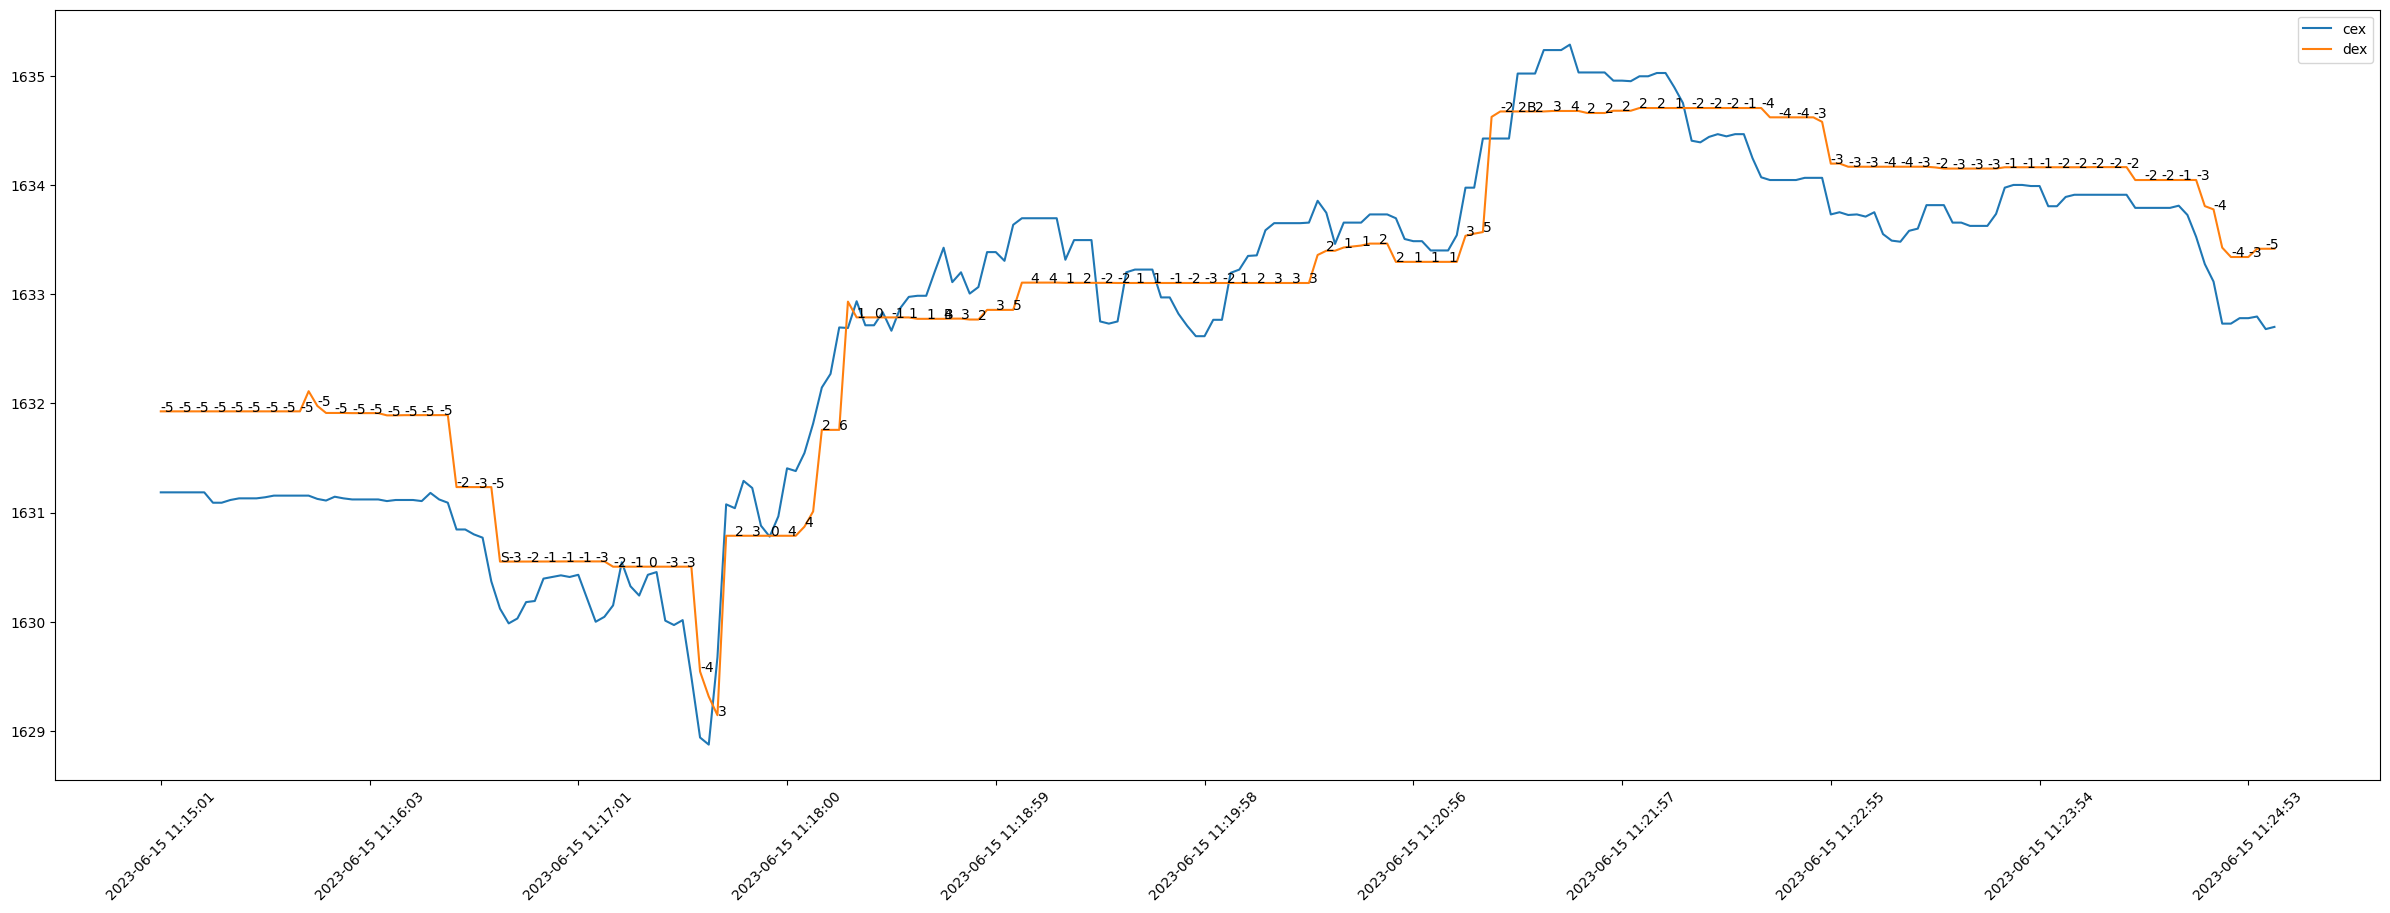

In [8]:
import matplotlib.pyplot as plt


def plot_ex_trade(plt_df, plt_trade_df, draw_every_point=False):
    plt.figure(figsize=(30, 10))
    plt.plot(plt_df["dex_datetime"], plt_df["cex_price"], label="cex")
    plt.plot(plt_df["dex_datetime"], plt_df["dex_price"], label="dex")

    data_cnt = len(plt_df)
    x_gap = int(data_cnt / 10)
    plt.xticks(plt_df["dex_datetime"][::x_gap], rotation=45)

    try:
        annotate_gap = int(x_gap / 10)
    except:
        annotate_gap = 1
    if draw_every_point:
        annotate_gap = 1
    for idx, row in plt_df.iterrows():
        if idx % annotate_gap == 0:
            plt.annotate(str(round(row["price_diff_in_tick"])), (row['dex_datetime'], row['dex_price']))

    for idx, row in plt_trade_df.iterrows():
        plt.annotate(row["trade_type"], (row['trade_datetime'], row['trade_price']))

    plt.legend()
    return plt


start_datetime = "2023-06-15 11:15:00"
end_datetime = "2023-06-15 11:25:00"
plt_df = df[(df["dex_datetime"] >= start_datetime) & (df["dex_datetime"] <= end_datetime)]
plt_trade_df = trade_df[(trade_df["trade_datetime"] >= start_datetime) & (trade_df["trade_datetime"] <= end_datetime)]
plt = plot_ex_trade(plt_df, plt_trade_df)
plt.show()